In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import cv2
import tensorflow as tf
from tensorflow.keras import layers, optimizers
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, Dropout
from tensorflow.keras.models import Model, load_model
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler


In [2]:
data=pd.read_csv("dataset.csv")
data.head()

,label,number_of_files
0,brain_glioma,2004
1,brain_menin,2004
2,brain_tumor,2048


In [3]:
brain_cancer_directory="Brain_Cancer/train"
os.listdir(brain_cancer_directory)

['brain_glioma', 'brain_menin', 'brain_tumor']

In [4]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
image_generator=ImageDataGenerator(rescale=1/255,validation_split=0.2)

In [5]:
train_generator=image_generator.flow_from_directory(batch_size=40,
                                                   directory=brain_cancer_directory,
                                                   shuffle=True,
                                                   target_size=(256,256),
                                                    class_mode="categorical",
                                                    subset="training"
                                                   )

Found 3852 images belonging to 3 classes.


In [6]:
val_generator=image_generator.flow_from_directory(batch_size=40,
                                                        directory=brain_cancer_directory,
                                                        shuffle=True,
                                                        target_size=(256,256),
                                                        class_mode="categorical",
                                                        subset="validation"
                                                        )

Found 960 images belonging to 3 classes.


In [7]:
train_images,train_labels=next(train_generator)

In [8]:
train_images.shape

(40, 256, 256, 3)

In [9]:
train_labels.shape

(40, 3)

In [10]:
## Visualizae Dataset

In [11]:
label_names={0:"brain_glioma",1:"brain_menin",2:"brain_tumor"}

#### Display the first 36 images of the trained images

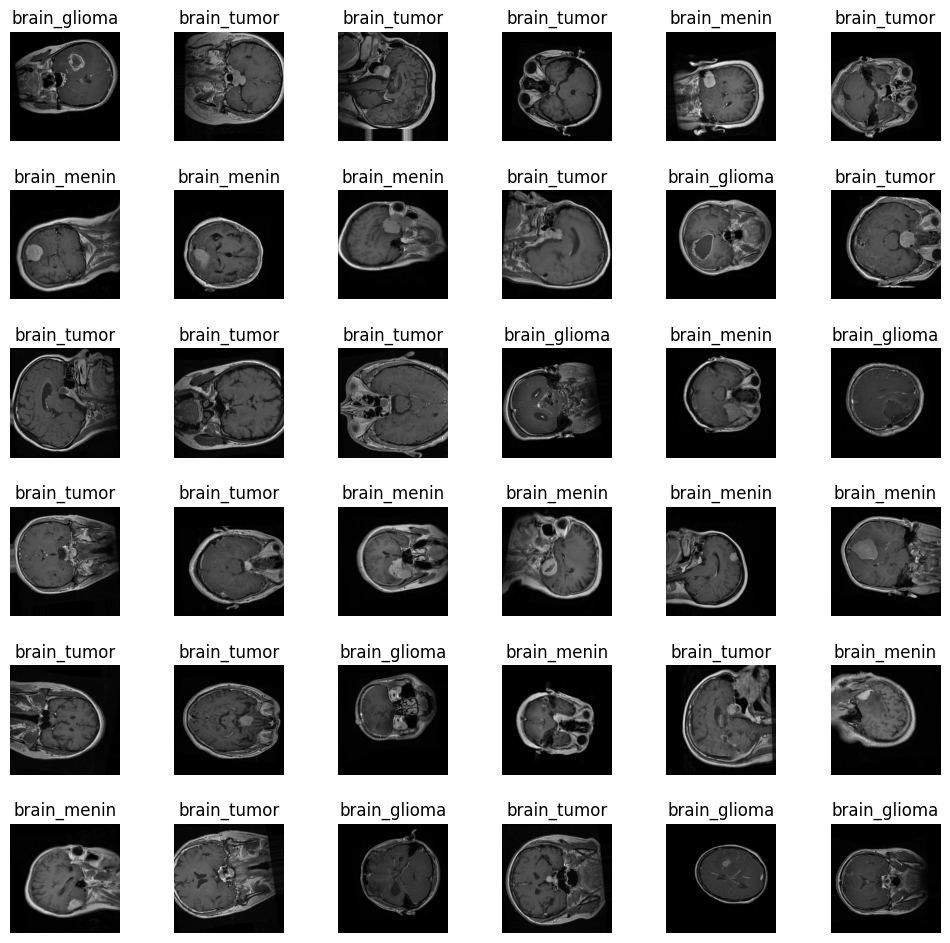

In [12]:
L=6
W=6
fig,axes=plt.subplots(L,W,figsize=(12,12))
axes=axes.ravel()
for i in np.arange(0,L*W):
    axes[i].imshow(train_images[i])
    axes[i].set_title(label_names[np.argmax(train_labels[i])])
    axes[i].axis("off")
plt.subplots_adjust(wspace=0.5)    


#### Import Model with Pretrained Weights

In [13]:
basemodel=ResNet50(weights="imagenet",include_top=False, input_tensor=Input(shape=(256,256,3)))

In [14]:
basemodel.summary()

Model: "resnet50"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 262, 262,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 128, 128,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 128, 128,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 128, 128,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 130, 130,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 64, 64,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 64, 64,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 64, 64,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 64, 64,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 64, 64,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 64, 64,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 64, 64,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 64, 64,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 64, 64,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 64, 64,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 64, 64,    │      1,024 │ conv2_block1_3_c

 Total params: 23,587,712 (89.98 MB)

 Trainable params: 23,534,592 (89.78 MB)

 Non-trainable params: 53,120 (207.50 KB)

In [15]:
for layer in basemodel.layers[:-10]:
    layer.trainable=False

#### Building and Train deep learning Modelm

In [16]:
headmodel=basemodel.output
headmodel=AveragePooling2D(pool_size=(4,4))(headmodel)
headmodel=Flatten(name="flatten")(headmodel)
headmodel=Dense(100,activation="relu")(headmodel)
headmodel=Dropout(0.5)(headmodel)
headmodel=Dense(100,activation="relu")(headmodel)
headmodel=Dropout(0.5)(headmodel)
headmodel=Dense(3,activation="softmax")(headmodel)

In [17]:
model=Model(inputs=basemodel.input,outputs=headmodel)
model.compile(loss="categorical_crossentropy",optimizer=optimizers.RMSprop(learning_rate=1e-4),metrics=["accuracy"])


In [18]:
earlystopping=EarlyStopping(monitor="val_loss",mode="min",patience=20)
checkpointer=ModelCheckpoint(filepath="weights.keras",verbose=1,save_best_only=True)

In [19]:
history=model.fit(train_generator,steps_per_epoch=1)

C:\Users\Kun Bi\anaconda3\envs\Data_Science\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
C:\Users\Kun Bi\anaconda3\envs\Data_Science\Lib\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor']. Received: the structure of inputs=*
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step - accuracy: 0.3250 - loss: 2.0905


In [20]:
history=model.fit(train_generator,epochs=8,
                 validation_data=val_generator,
                 callbacks=[checkpointer,earlystopping])

Epoch 1/8
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.3978 - loss: 1.1128
Epoch 1: val_loss improved from inf to 1.06155, saving model to weights.keras
97/97 ━━━━━━━━━━━━━━━━━━━━ 133s 1s/step - accuracy: 0.3981 - loss: 1.1122 - val_accuracy: 0.3396 - val_loss: 1.0616
Epoch 2/8
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5195 - loss: 0.9674
Epoch 2: val_loss did not improve from 1.06155
97/97 ━━━━━━━━━━━━━━━━━━━━ 135s 1s/step - accuracy: 0.5198 - loss: 0.9671 - val_accuracy: 0.3500 - val_loss: 1.0766
Epoch 3/8
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6317 - loss: 0.8596
Epoch 3: val_loss did not improve from 1.06155
97/97 ━━━━━━━━━━━━━━━━━━━━ 134s 1s/step - accuracy: 0.6319 - loss: 0.8593 - val_accuracy: 0.3479 - val_loss: 1.5149
Epoch 4/8
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6689 - loss: 0.7594
Epoch 4: val_loss improved from 1.06155 to 1.05285, saving model to weights.keras
97/97 ━━━━━━━━━━━━━━━━━━━━ 136s 1s/step - accuracy: 0.6690 - loss: 0.7

In [21]:
history.history.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

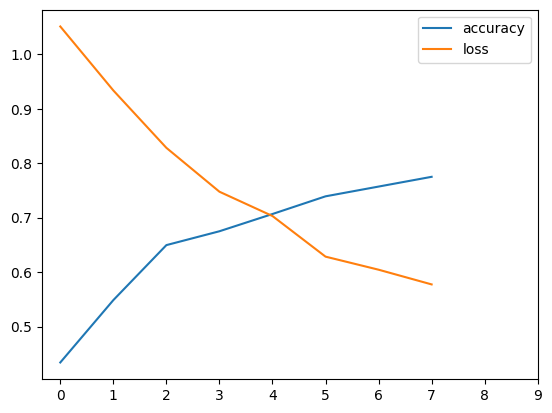

In [22]:
plt.plot(history.history["accuracy"],label="accuracy")
plt.plot(history.history["loss"],label="loss")
plt.xticks(range(0,10,1))
plt.legend()

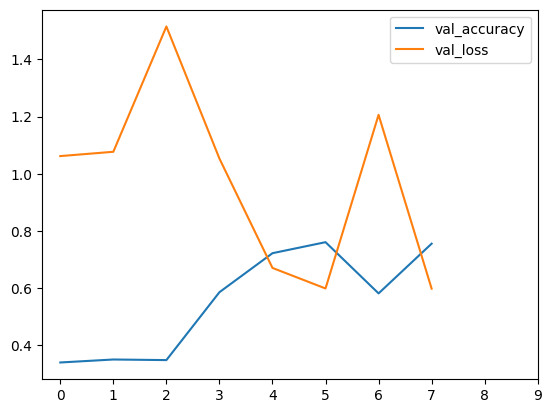

In [23]:
plt.plot(history.history["val_accuracy"],label="val_accuracy")
plt.plot(history.history["val_loss"],label="val_loss")
plt.xticks(range(0,10,1))
plt.legend()

In [24]:
test_directory="Brain_Cancer/test"
test_gen=ImageDataGenerator(rescale=1/255)
test_generator=test_gen.flow_from_directory(batch_size=40,
                                           directory=test_directory,
                                            shuffle=True,target_size=(256,256),
                                            class_mode="categorical")
evaluate=model.evaluate(test_generator,verbose=1)
print(f"Accuracy Test: {evaluate[1]}")

Found 1244 images belonging to 3 classes.
32/32 ━━━━━━━━━━━━━━━━━━━━ 31s 980ms/step - accuracy: 0.7435 - loss: 0.6303
Accuracy Test: 0.7395498156547546


In [25]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
prediction=[]
original=[]
image=[]

lst=["brain_glioma","brain_menin","brain_tumor"]
for i in range(len(os.listdir(test_directory))):
    for item in os.listdir(os.path.join(test_directory,lst[i])):
        img=cv2.imread(os.path.join(test_directory,lst[i],item))
        img=cv2.resize(img,(256,256))
        image.append(img)
        img=img/255
        img=img.reshape(-1,256,256,3)
        predict=model.predict(img)
        predict=np.argmax(predict)
        prediction.append(predict)
        original.append(i)

C:\Users\Kun Bi\anaconda3\envs\Data_Science\Lib\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor']. Received: the structure of inputs=*
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 893ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━

In [26]:
test_score=accuracy_score(original,prediction)
f"test accuracy: {test_score}."

'test accuracy: 0.7395498392282959.'

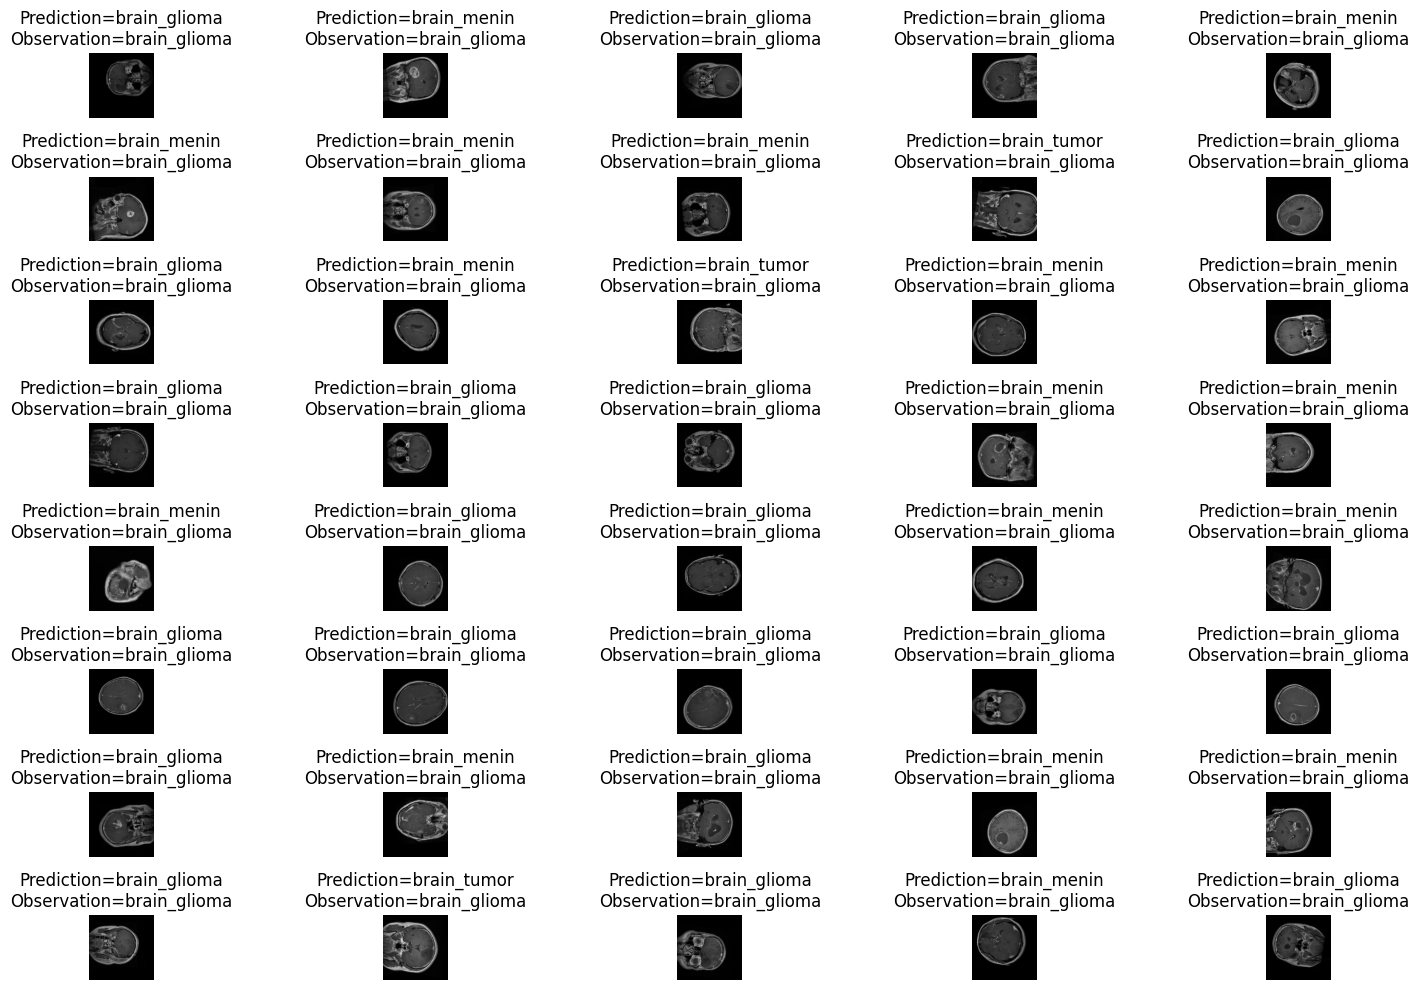

In [37]:
L=8
W=5
fig,axes=plt.subplots(L,W,figsize=(15,10))
axes=axes.ravel()
for i in np.arange(0,L*W):
    axes[i].imshow(image[i])
    axes[i].set_title(f"Prediction={str(label_names[prediction[i]])}\nObservation={str(label_names[original[i]])}")
    axes[i].axis("off")
plt.subplots_adjust(wspace=1.8)  
plt.tight_layout()
    

In [28]:
print(classification_report(np.asarray(original),np.asarray(prediction)))

              precision    recall  f1-score   support

           0       0.93      0.42      0.58       400
           1       0.60      0.87      0.71       400
           2       0.84      0.91      0.87       444

    accuracy                           0.74      1244
   macro avg       0.79      0.73      0.72      1244
weighted avg       0.79      0.74      0.73      1244



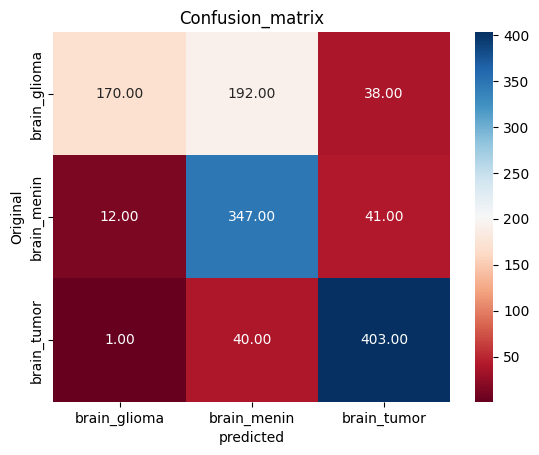

In [29]:
cm=confusion_matrix(np.asarray(original),np.asarray(prediction))
ax=plt.subplot()
sns.heatmap(cm,annot=True,ax=ax,cmap="RdBu",fmt="0.2f")
ax.set_xlabel("predicted")
ax.set_ylabel("Original")
ax.set_title("Confusion_matrix")
plt.xticks([0.5,1.5,2.5],["brain_glioma","brain_menin","brain_tumor"])
plt.yticks([0.5,1.5,2.5],["brain_glioma","brain_menin","brain_tumor"])
plt.show()